In [1]:
import os
import sys
from copy import deepcopy
from functools import partial
sys.path.insert(0, os.path.join("..", "..", ".."))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import torch.nn as nn
import torch

from well_logs import batchflow as bf
from well_logs import WellLogsDataset
from well_logs.batchflow.models.torch import UNet
from well_logs.batchflow.models.tf.losses import softmax_cross_entropy, dice


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class InitialBlock(nn.Module):
    def __init__(self, input_shapes):
        super().__init__()
        n_channels = input_shapes[0][1]
        # self.a = nn.Parameter(torch.tensor([1.] * n_channels, requires_grad=True))
        self.b = nn.Parameter(torch.tensor([1.] * n_channels, requires_grad=True))
        self.output_shape = input_shapes[0]

    def forward(self, inputs):
        x, masks = inputs
        A = x#  * self.a[..., np.newaxis]
        B = masks * self.b
        return A + B[..., np.newaxis]

class MyLoss(nn.Module):
    def forward(self, predictions, target):
        target, mask = target
        mse_element = mask[..., np.newaxis] * ((predictions - target) ** 2)
        return torch.sum(mse_element) / mask.sum() / predictions.shape[-1]    

class LogUNet(UNet):
    def initial_block(self, inputs, *args, **kwargs):
        return InitialBlock(inputs)

In [3]:
WELL_NPZ_PATH = "/notebooks/data/geolog/npz/*.npz"
ds = WellLogsDataset(path=WELL_NPZ_PATH, no_ext=True, sort=True)
ds.split(0.8, shuffle=42)

In [4]:
CROP_SIZE = 256

model_config = {
    'device': 'cuda:2',
    'initial_block/inputs': ('x', 'masks'),
    'inputs/x': {'shape': [12, CROP_SIZE]},
    'inputs/y': {'shape': [12, CROP_SIZE]},
    'inputs/masks': {'shape': (12, )},
    "head/num_classes": 12,
    'loss': MyLoss
}

In [5]:
N_EPOCH = 100
BATCH_SIZE = 32

In [6]:
import torch
torch.device('cuda:0')

device(type='cuda', index=0)

In [7]:
def concatenate_batch(batch, model, concat_mask=True):
    feed_dict = {"inputs": (np.concatenate(batch.logs).astype('float32'),
                            np.concatenate(batch.masks))}
    if concat_mask:
        feed_dict["targets"] = (np.concatenate(batch.target).astype('float32'),
                                np.concatenate(batch.masks))
    return feed_dict

In [8]:
FULL_SET = np.array(['CFTC', 'CILD', 'GR', 'GZ1', 'GZ2', 'GZ3', 'GZ4', 'GZ7', 'LLD', 'NKTD', 'PROX', 'SP'])

def sampler(x, size=4):
    return np.random.choice(x, size=size, replace=False)

template_train_ppl = (
    bf.Pipeline()
      .load(fmt="npz", components=["dept", "logs"])
      .init_variable('loss', init_on_each_run=list)
      .drop_nans()
      .convert_names()
      .add_components("target", bf.B("array_of_nones"))
      .add_components("masks", bf.B("array_of_nones"))
      .standardize(components="logs")
      .split_by_mnemonic(sampler, 'logs', 'target', FULL_SET)
      .random_crop(CROP_SIZE, n_crops=4, components=["logs", 'target'])
      .create_input_target("logs", "target", "masks", FULL_SET)
      .init_model('dynamic', LogUNet, 'model', model_config)
      .train_model('model', make_data=concatenate_batch, fetches='loss',
                   save_to=bf.V('loss'), mode='a')
      .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True,
           lazy=True, bar=True)
)

In [9]:
train_ppl = (ds.train >> template_train_ppl)
train_ppl.run()

100%|██████████| 800/800 [06:13<00:00,  2.32it/s]


График функции потерь в зависимости от числа эпох:

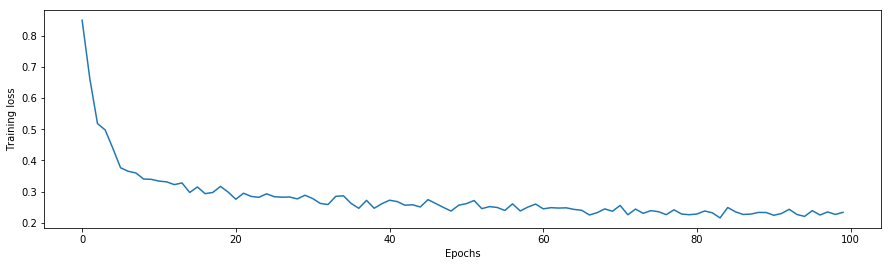

In [10]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss"), N_EPOCH)]

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

In [59]:
template_test_ppl = (
    bf.Pipeline()
      .load(fmt="npz", components=["dept", "logs"])
      .init_variable('output', init_on_each_run=list)
      .init_variable('input', init_on_each_run=list)
      .drop_nans()
      .convert_names()
      .add_components("target", bf.B("array_of_nones"))
      .add_components("masks", bf.B("array_of_nones"))
      .standardize(components="logs")
      .split_by_mnemonic(sampler, 'logs', 'target', FULL_SET)
      .random_crop(CROP_SIZE, n_crops=4, components=["logs", 'target'])
      .create_input_target("logs", "target", "masks", FULL_SET)
      .import_model('model', train_ppl)
      .predict_model('model', make_data=concatenate_batch, fetches='predictions',
                   save_to=bf.V('output'), mode='w')
      .update_variable('input', [bf.B('logs'), bf.B('target'), bf.B('masks'), bf.B('meta')], mode='w')
      .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True,
           lazy=True, bar=True)
)

In [60]:
test_ppl = (ds.test >> template_test_ppl)
test_ppl.next_batch()


  0%|          | 0/200 [00:00<?, ?it/s]

In [62]:
logs, target, masks, meta =  test_ppl.get_variable('input')

logs = np.concatenate(logs)
target = np.concatenate(target)
output = test_ppl.get_variable('output')
masks = np.concatenate(masks)

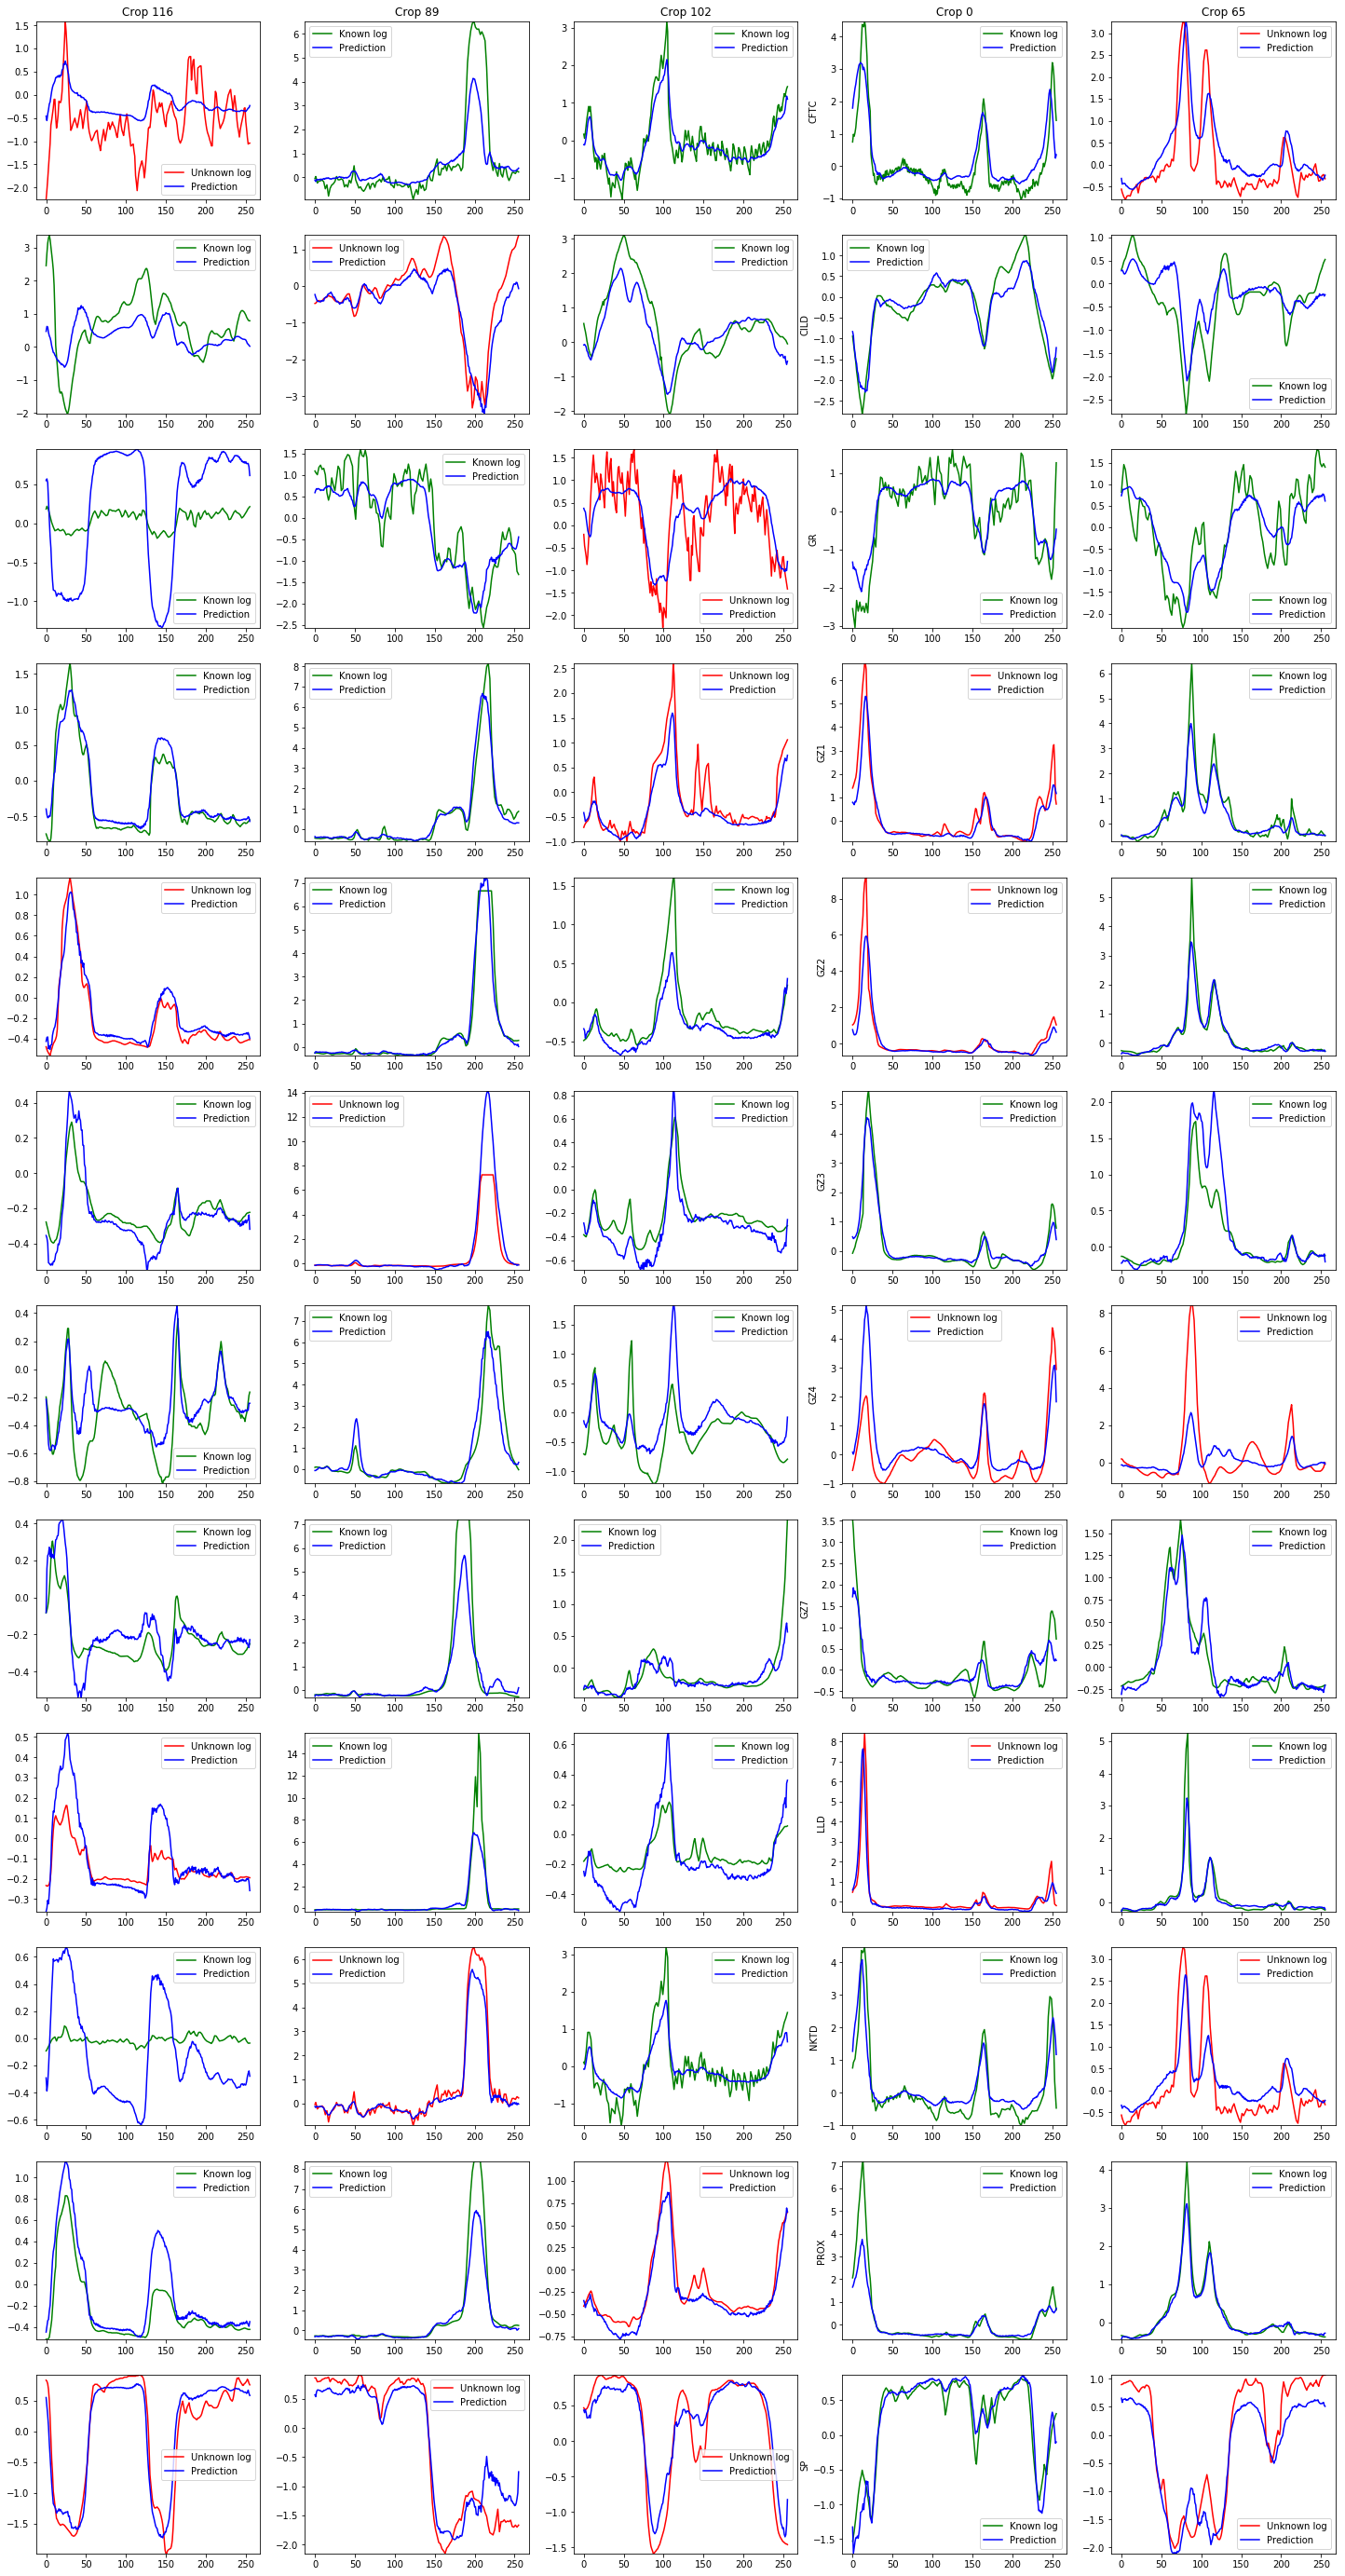

In [81]:
n_crops = 5

plt.figure(figsize=(5 * n_crops, 50))

random_indices = np.random.choice(range(len(logs)), n_crops, replace=False)

for i in range(12):
    for j, crop in enumerate(random_indices):
        ymax = max(logs[crop, i].max(), target[crop, i].max(), output[crop, i].max())
        ymin = min(logs[crop, i].min(), target[crop, i].min(), output[crop, i].min())

        plt.subplot(12, n_crops, n_crops * i + j + 1)
        if crop == 0:
            plt.ylabel(FULL_SET[i])
        if i == 0:
            plt.title('Crop {}'.format(crop))
        if masks[crop, i]:
            plt.plot(target[crop, i], color='r', label='Unknown log')
        else:
            plt.plot(logs[crop, i], color='g', label='Known log')

        plt.plot(output[crop, i], color='b', label='Prediction')
        plt.ylim((ymin, ymax))
        plt.legend()